In [142]:
from scipy.spatial import distance
import pickle
import torch
from torch import linalg
import numpy as np
from scipy.linalg import cho_solve

In [143]:
def load_object(repo: str, file: str):
    # Path constant to save the object
    PATH = f'{repo}/{file}.pkl'

    with open(PATH, 'rb') as f:
        return pickle.load(f)

In [144]:
features = load_object('../../data/train', 'donut')
features = torch.from_numpy(features)

In [145]:
features

tensor([[ 4.8302,  1.7729],
        [-3.0147,  3.6299],
        [-2.7704, -4.4909],
        ...,
        [ 4.9549, -0.0193],
        [-3.0155, -3.9369],
        [ 5.2306,  0.5260]], dtype=torch.float64)

In [168]:
C = 100
D = 2

means = torch.zeros(C, D, dtype=torch.float64).normal_()

mu0 = means[0]
mu1 = means[1]

In [179]:
L = 2 * torch.rand(C, 1, 1) * torch.eye(D, D).view(1, D, D)
sigmas = (L).type(torch.float64).contiguous()

S0 = torch.tril(sigmas[0]) @ torch.tril(sigmas[0]).t()
S1 = torch.tril(sigmas[1]) @ torch.tril(sigmas[1]).t()

print(mu0, mu1, S0, S1)

tensor([ 0.5289, -0.7358], dtype=torch.float64) tensor([ 0.5883, -0.0783], dtype=torch.float64) tensor([[1.8072, 0.0000],
        [0.0000, 1.8072]], dtype=torch.float64) tensor([[3.3420, 0.0000],
        [0.0000, 3.3420]], dtype=torch.float64)


In [180]:
def _sqrd_params(Si, Sj, mui, muj) -> torch.Tensor:
        # Compute the squared Gaussian params
        sigma = torch.inverse(Si + Sj)
        mu = sigma @ (Si @ mui + Sj @ muj)

        return (sigma, mu)

cluster_ids = torch.Tensor(range(C))
cartesian_ids = torch.cartesian_prod(cluster_ids, cluster_ids)
cartesian_ids = cartesian_ids.data.cpu().numpy().astype(int)

recomputed_params = {
    'means': [],
    'sigmas': []
}

for (i, j) in cartesian_ids:
    Si = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    Sj = torch.tril(sigmas[j]) @ torch.tril(sigmas[j]).t()
    
    sigma, mean = _sqrd_params(Si, Sj, means[i], means[j])
    
    recomputed_params['sigmas'].append(sigma.data.cpu().numpy())
    recomputed_params['means'].append(mean.data.cpu().numpy())

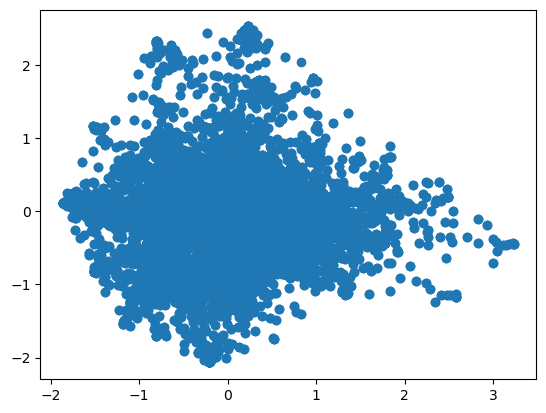

In [181]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(np.array(recomputed_params['means'])[:,0], np.array(recomputed_params['means'])[:,1])
plt.show()

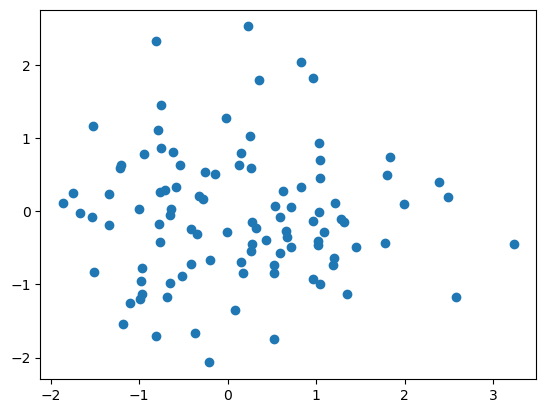

In [182]:
plt.scatter(means[:,0], means[:,1])
plt.show()

In [183]:
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

def _confidence_ellipse(ax, sigma, mu, n_std=2.3, facecolor='none', **kwargs):
        pearson = sigma[0][1]/np.sqrt(sigma[0][0] * sigma[1][1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)

        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(sigma[0][0]) * n_std
        mean_x = mu[0]

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(sigma[1][1]) * n_std
        mean_y = mu[1]

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

def plot_contours(means, sigmas):
        _, ax = plt.subplots()

        ax.axvline(c='grey', lw=1)
        ax.axhline(c='grey', lw=1)

        for i in range(C):
            sigma = sigmas[i]
            mu = means[i]
            
            config = {
                'alpha': .2
            }

            _confidence_ellipse(ax, sigma, mu, **config)
            ax.scatter(mu[0], mu[1], c='red', s=3)
        
        plt.plot()

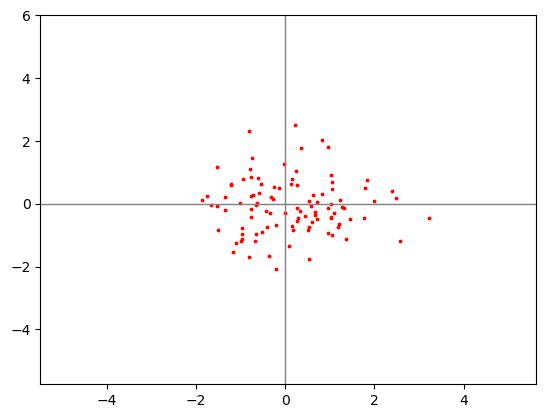

In [184]:
plot_contours(means.data.cpu().numpy(), sigmas.data.cpu().numpy())

In [185]:
sqrd_gen_variance = []

for i in range(C):
    S = recomputed_params['sigmas'][i]
    sqrd_gen_variance.append(np.linalg.det(S))

sqrd_gen_variance = np.array(sqrd_gen_variance)
sqrd_gen_variance

array([0.07654587, 0.0377161 , 0.07611851, 0.23660791, 0.226588  ,
       0.30617865, 0.18230817, 0.10536235, 0.22432719, 0.16394805,
       0.09560941, 0.3010291 , 0.05249819, 0.29728231, 0.03552381,
       0.09723428, 0.27413262, 0.04848881, 0.08053372, 0.19368062,
       0.22873104, 0.12395089, 0.15326113, 0.04581435, 0.27250265,
       0.24660016, 0.05280163, 0.0406749 , 0.05690462, 0.20884603,
       0.03810664, 0.03697749, 0.24153948, 0.08502472, 0.21937457,
       0.05798774, 0.1167789 , 0.19560861, 0.17404283, 0.08713236,
       0.30607724, 0.21430832, 0.1194029 , 0.17811847, 0.30398489,
       0.26819329, 0.30367492, 0.15834532, 0.03717527, 0.13704628,
       0.03088882, 0.03612263, 0.04646615, 0.08596937, 0.19585677,
       0.22367485, 0.06823776, 0.0878125 , 0.10689225, 0.06985522,
       0.07366102, 0.20332557, 0.09703028, 0.04778382, 0.03107789,
       0.23552468, 0.13711095, 0.29513575, 0.07498864, 0.03679878,
       0.12762162, 0.03503249, 0.06080236, 0.06282397, 0.23619

In [186]:
gen_variance = []

for i in range(C):
    S = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    S = S.data.cpu().numpy()
    
    gen_variance.append(np.linalg.det(S))

gen_variance = np.array(gen_variance)
gen_variance

array([3.26601567e+00, 1.11686322e+01, 3.30274001e+00, 6.18065430e-02,
       8.61848614e-02, 2.02158538e-10, 2.86056023e-01, 1.62191354e+00,
       9.24963292e-02, 4.38910304e-01, 2.03592888e+00, 2.37354275e-04,
       6.53937955e+00, 7.21246141e-04, 1.22392050e+01, 1.95922695e+00,
       1.05529433e-02, 7.47518191e+00, 2.94667026e+00, 2.16264163e-01,
       8.04902380e-02, 1.06741866e+00, 5.58246527e-01, 8.20678753e+00,
       1.17573122e-02, 4.26536171e-02, 6.47530518e+00, 9.92964039e+00,
       5.68744207e+00, 1.45151261e-01, 1.09925200e+01, 1.15132778e+01,
       5.17625624e-02, 2.63173067e+00, 1.07473819e-01, 5.50137474e+00,
       1.25234213e+00, 2.05949183e-01, 3.47875083e-01, 2.49807308e+00,
       9.83295940e-08, 1.24553101e-01, 1.18102150e+00, 3.16098981e-01,
       4.25571432e-05, 1.53165861e-02, 5.54877434e-05, 4.98176460e-01,
       1.14194697e+01, 7.99321520e-01, 1.50747294e+01, 1.19321677e+01,
       8.01946376e+00, 2.57078593e+00, 2.04650763e-01, 9.43771594e-02,
      

<BarContainer object of 2 artists>

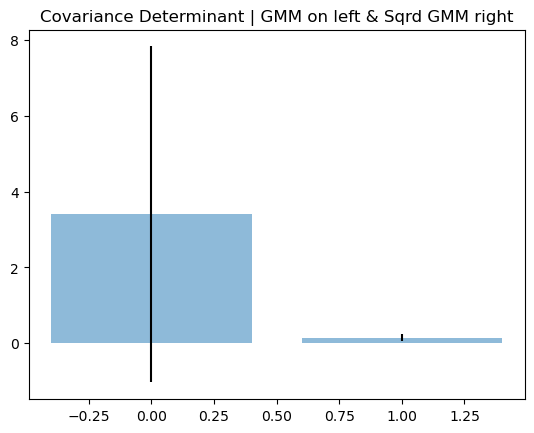

In [187]:
plt.title('Covariance Determinant | GMM on left & Sqrd GMM right')
plt.bar((0, 1), (gen_variance.mean(), sqrd_gen_variance.mean()), yerr=(gen_variance.std(), sqrd_gen_variance.std()), align='center', alpha=0.5)



In [188]:
print(sqrd_gen_variance.mean() - gen_variance.mean())

-3.252010869671299
